**Context :**

Pada era digital yang semakin maju, persaingan di industri telekomunikasi seluler semakin ketat. Salah satu tantangan yang dihadapi provider adalah mempertahankan pelanggan agar tidak beralih ke provider lain. Untuk itu, provider perlu mengetahui faktor-faktor yang menyebabkan pelanggan beralih. Seorang Data Scientist diminta untuk membuat model prediksi yang dapat memprediksi pelanggan yang akan beralih atau tidak dengan menggunakan machine learning.

Target :

0 : berlangganan

1 : Berhenti berlangganan (churn)

**Problem Statement  :**

Perusahaan telekomunikasi yang memiliki persentase churn yang tinggi berisiko mengalami kegagalan. Oleh karena itu, perlu dilakukan upaya untuk mengurangi persentase churn tersebut. Perusahaan umumnya lebih memilih untuk mempertahankan pelanggan, karena biaya yang dibutuhkan untuk mempertahankan pelanggan lebih rendah daripada biaya untuk memperoleh pelanggan baru. Berdasarkan [penelitian](https://www.outboundengine.com/blog/customer-retention-marketing-vs-customer-acquisition-marketing/), biaya untuk memperoleh pelanggan baru dapat lima kali lebih tinggi daripada biaya untuk mempertahankan pelanggan yang sudah ada. Biaya customer acquisition cost untuk industri telekomunikasi rata-rata adalah sekitar $315 [(sumber)](https://www.revechat.com/blog/customer-acquisition-cost/) per new customer.

Untuk mempertahankan pelanggan, perusahaan telekomunikasi dapat memberikan insentif retensi seperti potongan harga, paket layanan yang menarik, prioritas pelayanan, dan lain-lain. Namun, kebijakan pemberian insentif retensi belum sepenuhnya efektif. Hal ini dikarenakan insentif retensi yang diberikan secara merata kepada seluruh pelanggan akan menjadi tidak efektif dan mengurangi potensi keuntungan, terutama jika pelanggan tersebut memang loyal dan tidak ingin berhenti berlangganan.

**Goals :**

Oleh karena itu, perusahaan telekomunikasi (telco) ingin memiliki kemampuan untuk memprediksi kemungkinan pelanggan akan berhenti berlangganan. Perusahaan juga ingin mengetahui faktor-faktor yang menyebabkan pelanggan berhenti berlangganan. Dengan mengetahui faktor-faktor tersebut, perusahaan dapat melakukan tindakan untuk mencegah pelanggan berhenti berlangganan.

**Metric Evaluation :**


In [1]:
import warnings
warnings.filterwarnings('ignore')

#   data manipulation
import pandas as pd
import numpy as np

#   data prepocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer

from category_encoders import BinaryEncoder

#   model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#   ensemble
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

#   model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold

#   pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imb_pipeline

#   metric
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, fbeta_score, roc_auc_score
from imblearn.metrics import classification_report_imbalanced

#   visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#   balancing
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTEN, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
from imblearn.combine import SMOTEENN, SMOTETomek

In [111]:
df = pd.read_csv(r"C:\Users\moh_y\python_project\bootcamp\modul_3\capstone\data_telco_customer_churn.csv")
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [112]:
# df['Churn'] = df['Churn'].astype('bool')

In [113]:
#   cek data duplicated

print(f"jumlah data duplikat = {df.duplicated().sum()}")

#   hilangkan data duplicated
df = df[~df.duplicated()]


jumlah data duplikat = 77


In [114]:
pd.set_option('display.max_colwidth', None)
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,Dependents,2,"[Yes, No]"
1,tenure,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1, 48, 13, 58, 7, 4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56, 32, 26, 24, 2, 51, 23, 49, 28, 36, 45, 42, 6, 61, 59, 67, 65, 0, 16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46, 39, 29, 38, 68, 21]"
2,OnlineSecurity,3,"[No, Yes, No internet service]"
3,OnlineBackup,3,"[No, Yes, No internet service]"
4,InternetService,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,3,"[Yes, No internet service, No]"
6,TechSupport,3,"[Yes, No, No internet service]"
7,Contract,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,2,"[Yes, No]"
9,MonthlyCharges,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7, 44.05, 73.5, 40.3, 33.6, 96.25, 70.45, 30.55, 44.8, 20.0, 81.5, 94.35, 35.3, 50.7, 106.05, 56.3, 20.65, 98.9, 40.2, 81.2, 19.45, 116.1, 55.2, 94.45, 84.85, 19.6, 79.0, 74.7, 30.4, 55.8, 104.5, 70.55, 55.25, 96.65, 88.85, 109.25, 104.75, 74.4, 79.4, 74.1, 73.05, 94.6, 70.35, 79.6, 79.5, 90.7, 81.0, 87.75, 118.65, 24.8, 105.25, 57.8, 19.0, 25.7, 54.2, 44.85, 19.95, 81.05, 20.35, 85.25, 67.45, 100.3, 20.95, 105.2, 26.35, 82.15, 102.6, 106.15, 23.95, 115.8, 66.85, 90.35, 89.85, 73.35, 104.45, 35.45, 88.4, 70.5, 25.1, 39.0, 83.25, 74.3, 54.3, 50.45, 86.0, 19.55, 103.5, 91.7, 64.85, 99.65, 68.75, 106.25, 75.9, 94.4, ...]"


In [115]:
# cek deksripsi kolom `tenure` dan `MonthlyCharges`
df.describe()

,tenure,MonthlyCharges
count,4853.000000,4853.000000
mean,32.679992,65.321543
std,24.395554,29.783655
min,0.000000,18.800000
25%,9.000000,40.050000
50%,29.000000,70.600000
75%,56.000000,90.050000
max,72.000000,118.650000


In [116]:
#   cek data kosong
df.isna().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

In [117]:
df['Churn'] = np.where(df['Churn']=='Yes', 1, 0)

Presentase Churn
0    0.73
1    0.27
Name: count, dtype: float64


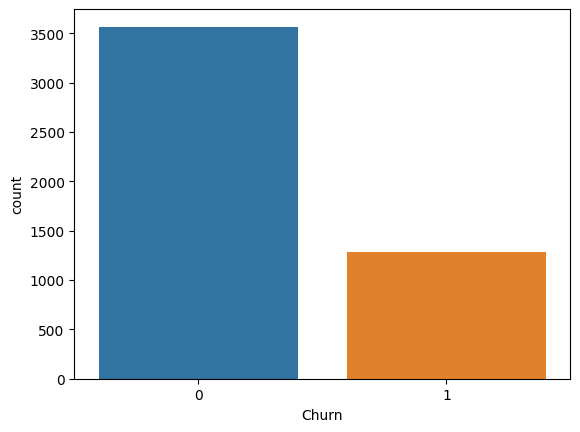

In [118]:
df_feature = df.drop(columns='Churn')
df_target = df['Churn']

print(f"Presentase {(df['Churn'].value_counts() / len(df)).round(2)}")

sns.countplot(x=df['Churn'])
plt.show()

In [119]:
#   split ke dalam 2 subset (training dan testing)
#   stratify berfungsi untuk menyamakan proporsi 'target' pada data training dan data testing
x_train, x_test, y_train, y_test = train_test_split(df_feature, df_target, test_size=0.2, random_state=48, stratify=df_target)

display(y_train.value_counts(normalize=True).round(2),
        y_test.value_counts(normalize=True).round(2),)

Churn
0    0.73
1    0.27
Name: proportion, dtype: float64

Churn
0    0.73
1    0.27
Name: proportion, dtype: float64

# model benchmark without balancing

In [120]:
method = None
transformer = ColumnTransformer(
    [('scaling', method, ['MonthlyCharges']),
     ('OHE', OneHotEncoder(drop='first'), x_train.select_dtypes(include='O').columns)
     ], remainder='passthrough'
)
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling', None, ['MonthlyCharges']),
                                ('OHE', OneHotEncoder(drop='first'),
                                 Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object'))])

In [121]:
#   model init

model = None
logreg = LogisticRegression(random_state=48)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=48)
svc = SVC(random_state=48)

In [122]:
pipe = imb_pipeline([
    ('prepocessing', transformer),
    ('clf', model)
])

In [123]:
#   membuat f2 score
f2 = make_scorer(fbeta_score, beta=2)

In [124]:
model_search = {
    'clf' : [logreg, knn, dt, svc],
    'prepocessing__scaling' : [MinMaxScaler(), RobustScaler(), StandardScaler()]
} 

grid_search_cv = GridSearchCV(
    estimator = pipe,
    param_grid = model_search,
    scoring = f2,
    verbose=2,  # setiap proses dikeluarkan
    return_train_score=True,
    cv = StratifiedKFold()
)

In [125]:
grid_search_cv.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=MinMaxScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=MinMaxScaler(); total time=   0.0s


[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=MinMaxScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=MinMaxScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=MinMaxScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=RobustScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=RobustScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=RobustScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=RobustScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=RobustScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(random_state=48), prepocessing__scaling=StandardScaler(); total time=   0.0s
[CV] END clf=LogisticRegression(ran

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prepocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         None,
                                                                         ['MonthlyCharges']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object'))])),
                                       ('clf', None)]),
             param_grid={'clf': [LogisticRegression(random_state=48),
                                 KNeighborsClassifier(),
                                 DecisionTreeClassifier(random_state=48),
                                 SVC(random_state=48)],
                         'prepocessing__scaling': [MinMaxScaler(),
                                                   RobustScaler(),
                                                   StandardScaler()]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=2)

In [126]:
grid_search_cv.best_score_

0.5580572296309029

In [127]:
grid_search_cv.best_params_

{'clf': LogisticRegression(random_state=48),
 'prepocessing__scaling': MinMaxScaler()}

In [128]:
cv_result = pd.DataFrame(grid_search_cv.cv_results_)
cv_result.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_prepocessing__scaling,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.063758,0.002165,0.007884,0.000765,LogisticRegression(random_state=48),MinMaxScaler(),"{'clf': LogisticRegression(random_state=48), 'prepocessing__scaling': MinMaxScaler()}",0.516032,0.540675,0.565086,...,0.558057,0.026419,1,0.567101,0.567926,0.555973,0.538404,0.563768,0.558634,0.010961
2,0.050000,0.006250,0.009375,0.007655,LogisticRegression(random_state=48),StandardScaler(),"{'clf': LogisticRegression(random_state=48), 'prepocessing__scaling': StandardScaler()}",0.520521,0.535183,0.570131,...,0.556835,0.024593,2,0.566132,0.566392,0.560409,0.543424,0.558617,0.558995,0.008370
1,0.051448,0.005629,0.010242,0.006734,LogisticRegression(random_state=48),RobustScaler(),"{'clf': LogisticRegression(random_state=48), 'prepocessing__scaling': RobustScaler()}",0.516032,0.540675,0.565657,...,0.556374,0.024961,3,0.566274,0.567500,0.561798,0.543424,0.558757,0.559551,0.008650
5,0.015495,0.000246,0.012501,0.006250,KNeighborsClassifier(),StandardScaler(),"{'clf': KNeighborsClassifier(), 'prepocessing__scaling': StandardScaler()}",0.492537,0.564672,0.560472,...,0.541671,0.026276,4,0.667326,0.660728,0.657830,0.654275,0.658122,0.659656,0.004350
3,0.003125,0.006250,0.012506,0.006253,KNeighborsClassifier(),MinMaxScaler(),"{'clf': KNeighborsClassifier(), 'prepocessing__scaling': MinMaxScaler()}",0.473108,0.566860,0.559921,...,0.539450,0.033964,5,0.666090,0.657178,0.652767,0.656591,0.655232,0.657572,0.004522


# model benchmark with balancing

In [129]:
pipe_balance = imb_pipeline([
    ('prepocessing', transformer),
    ('sampling', None),
    ('clf', model)
])

In [130]:
model_search = {
    'clf' : [logreg, knn, dt, svc],
    'prepocessing__scaling' : [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'sampling' : [RandomOverSampler(random_state=48),
                  RandomUnderSampler(random_state=48)
                  ]
} 

grid_search_cv_balance = GridSearchCV(
    estimator = pipe_balance,
    param_grid = model_search,
    scoring = f2,
    verbose=1,  # setiap proses dikeluarkan
    return_train_score=True,
    cv = StratifiedKFold()
)

grid_search_cv_balance.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prepocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         None,
                                                                         ['MonthlyCharges']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'C...
             param_grid={'clf': [LogisticRegression(random_state=48),
                                 KNeighborsClassifier(),
                                 DecisionTreeClassifier(random_state=48),
                                 SVC(random_state=48)],
                         'prepocessing__scaling': [MinMaxScaler(),
                                                   RobustScaler(),
                                                   StandardScaler()],
                         'sampling': [RandomOverSampler(random_state=48),
                                      RandomUnderSampler(random_state=48)]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=1)

In [131]:
grid_search_cv_balance.best_score_

0.7193997966945886

In [132]:
grid_search_cv_balance.best_params_

{'clf': LogisticRegression(random_state=48),
 'prepocessing__scaling': MinMaxScaler(),
 'sampling': RandomOverSampler(random_state=48)}

In [133]:
cv_result = pd.DataFrame(grid_search_cv_balance.cv_results_)
cv_result.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_prepocessing__scaling,param_sampling,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.065763,0.007361,0.007933,0.006881,LogisticRegression(random_state=48),MinMaxScaler(),RandomOverSampler(random_state=48),"{'clf': LogisticRegression(random_state=48), 'prepocessing__scaling': MinMaxScaler(), 'sampling': RandomOverSampler(random_state=48)}",0.723570,0.711775,...,0.719400,0.011690,1,0.720395,0.723010,0.729983,0.725614,0.727233,0.725247,0.003318
1,0.053125,0.007654,0.009532,0.007788,LogisticRegression(random_state=48),MinMaxScaler(),RandomUnderSampler(random_state=48),"{'clf': LogisticRegression(random_state=48), 'prepocessing__scaling': MinMaxScaler(), 'sampling': RandomUnderSampler(random_state=48)}",0.735800,0.703606,...,0.718821,0.013523,2,0.721627,0.717406,0.723928,0.727882,0.723655,0.722900,0.003414
2,0.059375,0.006249,0.006250,0.007655,LogisticRegression(random_state=48),RobustScaler(),RandomOverSampler(random_state=48),"{'clf': LogisticRegression(random_state=48), 'prepocessing__scaling': RobustScaler(), 'sampling': RandomOverSampler(random_state=48)}",0.723570,0.708627,...,0.718638,0.011718,3,0.719141,0.722077,0.726580,0.725456,0.726318,0.723914,0.002878
3,0.053124,0.007655,0.003125,0.006250,LogisticRegression(random_state=48),RobustScaler(),RandomUnderSampler(random_state=48),"{'clf': LogisticRegression(random_state=48), 'prepocessing__scaling': RobustScaler(), 'sampling': RandomUnderSampler(random_state=48)}",0.735168,0.703606,...,0.718568,0.013328,4,0.724590,0.717562,0.724401,0.726051,0.724130,0.723347,0.002968
4,0.057559,0.006395,0.009375,0.007655,LogisticRegression(random_state=48),StandardScaler(),RandomOverSampler(random_state=48),"{'clf': LogisticRegression(random_state=48), 'prepocessing__scaling': StandardScaler(), 'sampling': RandomOverSampler(random_state=48)}",0.722944,0.706760,...,0.717388,0.010463,5,0.719298,0.721919,0.729983,0.725929,0.728187,0.725063,0.003945


# benchmarking with sampling (ensemble model)

In [134]:
models = [
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=48)),
    ('LogisticRegression', LogisticRegression(random_state=48)),
    ('KNeighborsClassifier', KNeighborsClassifier())
]
voting = VotingClassifier(estimators=models, 
                        voting='soft',
                        verbose=True)

stack = StackingClassifier( estimators=models,
                            cv= 5,
                            final_estimator=LogisticRegression(random_state=48),
                            verbose= True # default meta learner : logistic reg
                            )

bagging = BaggingClassifier(estimator=KNeighborsClassifier(), random_state=48)
rf = RandomForestClassifier(random_state=48)

#   boosting
xgb = XGBClassifier(random_state = 48,device='cuda')
gds = GradientBoostingClassifier(random_state=48)
adaboost = AdaBoostClassifier(random_state=48)
lgbm = LGBMClassifier(random_state=48)

In [135]:
model_search = {
    'clf' : [stack, voting, bagging, rf],
    'prepocessing__scaling' : [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'sampling' : [RandomOverSampler(random_state=48),
                  RandomUnderSampler(random_state=48)
                  ]
} 

grid_search_cv_balance_ensemble = GridSearchCV(
    estimator = pipe_balance,
    param_grid = model_search,
    scoring = f2,
    verbose=1,  # setiap proses dikeluarkan
    return_train_score=True,
    cv = StratifiedKFold()
)

grid_search_cv_balance_ensemble.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Voting] ... (1 of 3) Processing DecisionTreeClassifier, total=   0.0s
[Voting] ....... (2 of 3) Processing LogisticRegression, total=   0.1s
[Voting] ..... (3 of 3) Processing KNeighborsClassifier, total=   0.0s
[Voting] ... (1 of 3) Processing DecisionTreeClassifier, total=   0.0s
[Voting] ....... (2 of 3) Processing LogisticRegression, total=   0.0s
[Voting] ..... (3 of 3) Processing KNeighborsClassifier, total=   0.0s
[Voting] ... (1 of 3) Processing DecisionTreeClassifier, total=   0.0s
[Voting] ....... (2 of 3) Processing LogisticRegression, total=   0.1s
[Voting] ..... (3 of 3) Processing KNeighborsClassifier, total=   0.0s
[Voting] ... (1 of 3) Processing DecisionTreeClassifier, total=   0.0s
[Voting] ....... (2 of 3) Processing LogisticRegression, total=   0.1s
[Voting] ..... (3 of 3) Processing KNeighborsClassifier, total=   0.0s
[Voting] ... (1 of 3) Processing DecisionTreeClassifier, total=   0.0s
[Voting] ......

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prepocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         None,
                                                                         ['MonthlyCharges']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'C...
                                                  verbose=True, voting='soft'),
                                 BaggingClassifier(estimator=KNeighborsClassifier(),
                                                   random_state=48),
                                 RandomForestClassifier(random_state=48)],
                         'prepocessing__scaling': [MinMaxScaler(),
                                                   RobustScaler(),
                                                   StandardScaler()],
                         'sampling': [RandomOverSampler(random_state=48),
                                      RandomUnderSampler(random_state=48)]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=1)

In [136]:
model_search = {
    'clf' : [xgb, lgbm, adaboost, gds],
    'prepocessing__scaling' : [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'sampling' : [RandomOverSampler(random_state=48),
                  RandomUnderSampler(random_state=48)
                  ]
} 

grid_search_cv_balance_boosting = GridSearchCV(
    estimator = pipe_balance,
    param_grid = model_search,
    scoring = f2,
    verbose=1,  # setiap proses dikeluarkan
    return_train_score=True,
    cv = StratifiedKFold()
)

grid_search_cv_balance_boosting.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 2281, number of negative: 2281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 4562, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2281, number of negative: 2281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 4562, number of used features: 16
[LightGBM] [Info] [

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prepocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         None,
                                                                         ['MonthlyCharges']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'C...
                                               random_state=48, ...),
                                 LGBMClassifier(random_state=48),
                                 AdaBoostClassifier(random_state=48),
                                 GradientBoostingClassifier(random_state=48)],
                         'prepocessing__scaling': [MinMaxScaler(),
                                                   RobustScaler(),
                                                   StandardScaler()],
                         'sampling': [RandomOverSampler(random_state=48),
                                      RandomUnderSampler(random_state=48)]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=1)

In [137]:
grid_search_cv_balance_ensemble.best_score_

0.717846216284596

In [138]:
grid_search_cv_balance_boosting.best_score_

0.7296223022423151

In [139]:
grid_search_cv_balance_boosting.best_estimator_

Pipeline(steps=[('prepocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', MinMaxScaler(),
                                                  ['MonthlyCharges']),
                                                 ('OHE',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object'))])),
                ('sampling', RandomUnderSampler(random_state=48)),
                ('clf', AdaBoostClassifier(random_state=48))])

In [140]:
grid_search_cv_balance_ensemble.best_estimator_

Pipeline(steps=[('prepocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['MonthlyCharges']),
                                                 ('OHE',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object'))])),
                ('sampling', RandomUnderSampler(random_state=48)),
                ('clf',
                 StackingClassifier(cv=5,
                                    estimators=[('DecisionTreeClassifier',
                                                 DecisionTreeClassifier(random_state=48)),
                                                ('LogisticRegression',
                                                 LogisticRegression(random_state=48)),
                                                ('KNeighborsClassifier',
                                                 KNeighborsClassifier())],
                                    final_estimator=LogisticRegression(random_state=48),
                                    verbose=True))])

In [141]:
cv_result = pd.DataFrame(grid_search_cv_balance_ensemble.cv_results_)
cv_result.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_prepocessing__scaling,param_sampling,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,0.300399,0.006277,0.012506,0.006253,"StackingClassifier(cv=5,\n estimators=[('DecisionTreeClassifier',\n DecisionTreeClassifier(random_state=48)),\n ('LogisticRegression',\n LogisticRegression(random_state=48)),\n ('KNeighborsClassifier',\n KNeighborsClassifier())],\n final_estimator=LogisticRegression(random_state=48),\n verbose=True)",RobustScaler(),RandomUnderSampler(random_state=48),"{'clf': StackingClassifier(cv=5, estimators=[('DecisionTreeClassifier', DecisionTreeClassifier(random_state=48)), ('LogisticRegression', LogisticRegression(random_state=48)), ('KNeighborsClassifier', KNeighborsClassifier())], final_estimator=LogisticRegression(random_state=48), verbose=True), 'prepocessing__scaling': RobustScaler(), 'sampling': RandomUnderSampler(random_state=48)}",0.732871,0.698497,...,0.717846,0.014554,1,0.744329,0.744074,0.758666,0.738116,0.746482,0.746333,0.006764
1,0.302436,0.005974,0.015633,0.000015,"StackingClassifier(cv=5,\n estimators=[('DecisionTreeClassifier',\n DecisionTreeClassifier(random_state=48)),\n ('LogisticRegression',\n LogisticRegression(random_state=48)),\n ('KNeighborsClassifier',\n KNeighborsClassifier())],\n final_estimator=LogisticRegression(random_state=48),\n verbose=True)",MinMaxScaler(),RandomUnderSampler(random_state=48),"{'clf': StackingClassifier(cv=5, estimators=[('DecisionTreeClassifier', DecisionTreeClassifier(random_state=48)), ('LogisticRegression', LogisticRegression(random_state=48)), ('KNeighborsClassifier', KNeighborsClassifier())], final_estimator=LogisticRegression(random_state=48), verbose=True), 'prepocessing__scaling': MinMaxScaler(), 'sampling': RandomUnderSampler(random_state=48)}",0.729167,0.699115,...,0.716482,0.014688,2,0.745595,0.742976,0.754038,0.740700,0.743556,0.745373,0.004604
5,0.299959,0.004585,0.010752,0.004165,"StackingClassifier(cv=5,\n estimators=[('DecisionTreeClassifier',\n DecisionTreeClassifier(random_state=48)),\n ('LogisticRegression',\n LogisticRegression(random_state=48)),\n ('KNeighborsClassifier',\n KNeighborsClassifier())],\n final_estimator=LogisticRegression(random_state=48),\n verbose=True)",StandardScaler(),RandomUnderSampler(random_state=48),"{'clf': StackingClassifier(cv=5, estimators=[('DecisionTreeClassifier', DecisionTreeClassifier(random_state=48)), ('LogisticRegression', LogisticRegression(random_state=48)), ('KNeighborsClassifier', KNeighborsClassifier())], final_estimator=LogisticRegression(random_state=48), verbose=True), 'prepocessing__scaling': StandardScaler(), 'sampling': RandomUnderSampler(random_state=48)}",0.734144,0.699115,...,0.714968,0.014552,3,0.742127,0.743910,0.752618,0.739651,0.741516,0.743965,0.004536
17,0.024907,0.002839,0.032633,0.002316,"BaggingClassifier(estimator=KNeighborsClassifier(), random_state=48)",StandardScaler(),RandomUnderSampler(random_state=48),"{'clf': BaggingClassifier(estimator=KNeighborsClassifier(), random_state=48), 'prepocessing__scaling': StandardScaler(), 'sampling': RandomUnderSampler(random_state=48)}",0.700422,0.693860,...,0.699077,0.004577,4,0.759062,0.757736,0.759062,0.762227,0.761834,0.759984,0.001744
15,0.023012,0.002348,0.034595,0.003170,"BaggingClassifier(estimator=KNeighborsClassifier(), random_state=48)",RobustScaler(),RandomUnderSampler(random_state=48),"{'clf': BaggingClassifier(estimator=KNeighborsClassifier(), random_state=48), 'prepocessing__scaling': RobustScaler(), 'sampling': RandomUnderSampler(random_state=48)}",0.701606,0.689655,...,0.698262,0.005233,5,0.758643,0.759788,0.764494,0.765576,0.767853,0.763271,0.003503


In [142]:
transformer_crs_val = ColumnTransformer(
    [('scaling', MinMaxScaler(), ['MonthlyCharges']),
     ('OHE', OneHotEncoder(drop='first'), x_train.select_dtypes(include='O').columns)
     ], remainder='passthrough'
)
transformer_crs_val

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling', MinMaxScaler(), ['MonthlyCharges']),
                                ('OHE', OneHotEncoder(drop='first'),
                                 Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object'))])

In [143]:
# Your code here
def eval(model):
    pipe = Pipeline([
    ('prepocessing', transformer_crs_val),
    (f'model_{model}', model)
    ])

    result_reg = cross_validate(pipe, 
                            x_train, 
                            y_train,
                            cv=StratifiedKFold(), 
                            scoring=f2, 
                            return_train_score=True)
    
    return model,result_reg['test_score'],result_reg['train_score']

In [144]:
list_model = [logreg, stack, adaboost]

model_benchmark = {
    'model' : [],
    'test_f2' : [],
    'train_f2' : [],
    'std_test' : [],
    'std_train' : []

}

for model in list_model:
    name, test_f2, train_f2 = eval(model)
    model_benchmark['model'].append(name)
    model_benchmark['test_f2'].append(np.mean(abs(test_f2)))
    model_benchmark['train_f2'].append(np.mean(abs(train_f2)))
    model_benchmark['std_test'].append(np.std(abs(test_f2)))
    model_benchmark['std_train'].append(np.std(abs(train_f2)))

pd.DataFrame(model_benchmark).sort_values(by='test_f2', ascending=False)

,model,test_f2,train_f2,std_test,std_train
0,LogisticRegression(random_state=48),0.558057,0.558634,0.026419,0.010961
2,AdaBoostClassifier(random_state=48),0.546100,0.562516,0.018166,0.010655
1,"StackingClassifier(cv=5,\n estimators=[('DecisionTreeClassifier',\n DecisionTreeClassifier(random_state=48)),\n ('LogisticRegression',\n LogisticRegression(random_state=48)),\n ('KNeighborsClassifier',\n KNeighborsClassifier())],\n final_estimator=LogisticRegression(random_state=48),\n verbose=True)",0.525446,0.581784,0.026626,0.013545


# hyperparameter tuning adaboost

In [145]:
model_search = {
    'clf' : [xgb, lgbm, adaboost, gds],
    'prepocessing__scaling' : [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'sampling' : [RandomOverSampler(random_state=48),
                  RandomUnderSampler(random_state=48)
                  ]
} 

grid_search_cv_balance_boosting = GridSearchCV(
    estimator = pipe_balance,
    param_grid = model_search,
    scoring = f2,
    verbose=1,  # setiap proses dikeluarkan
    return_train_score=True,
    cv = StratifiedKFold()
)

grid_search_cv_balance_boosting.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 2281, number of negative: 2281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 4562, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2281, number of negative: 2281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 4562, number of used features: 16
[LightGBM] [Info] [

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prepocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         None,
                                                                         ['MonthlyCharges']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'C...
                                               random_state=48, ...),
                                 LGBMClassifier(random_state=48),
                                 AdaBoostClassifier(random_state=48),
                                 GradientBoostingClassifier(random_state=48)],
                         'prepocessing__scaling': [MinMaxScaler(),
                                                   RobustScaler(),
                                                   StandardScaler()],
                         'sampling': [RandomOverSampler(random_state=48),
                                      RandomUnderSampler(random_state=48)]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=1)